remembering normalization scaling and etc

In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pylab as plt 

In [2]:
# тут в класі додаткові функції, які я або свіснув або через чат
class AdditionalFunctions:
  # свіснув код з якогось сайтика
  @staticmethod
  def frange(start,end,step):
    if step == 0 : raise ValueError("frange() step argument must not be zero")
    if (end-start)/step <= 0: step = -step
    while abs(start) <= abs(end):
      yield start
      start += step
      
  # а це чатік написав
  @staticmethod
  def convert_to_float(s) -> float:
    if not isinstance(s, str):
        return math.nan  # Return NaN for non-string input
    
    parts = s.split('.')
    if len(parts) > 2:
        s = parts[0] + '.' + ''.join(parts[1:])  # Fix multiple dots
    
    try:
        return float(s)
    except ValueError:
        return math.nan  # Return NaN for invalid float conversion
      
  @staticmethod
  def fix_coordinates(coord):
    """
    Convert incorrectly formatted coordinates (with '.' as thousand separators) into floats.
    Validates input to handle NaN values and ensure it's a string.

    Example:
    "13.012.793" -> 13.012793
    "80.289.982" -> 80.289982
    """
    if pd.isna(coord) or not isinstance(coord, str):
        return None  # Return None for NaN values or non-string inputs

    parts = coord.split(".")
    if len(parts) > 2:
        return float(parts[0] + "." + "".join(parts[1:]))
    return float(coord)  # Handle cases where no correction is needed


In [3]:
# а цей клас шоб покроково чистить датасетик
class FoodTimeCleaner:
  def __init__(self):
    pass
  
  def clean(self, df: pd.DataFrame) -> pd.DataFrame:
    # списки окремих колонок які будем чистить
    id_cols = ['ID', 'Delivery_person_ID',]
    coord_cols = ['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude']
    target_col = 'TARGET'
    
    # чистим по отих окремих колонках (окремі бо вони по свому були записані і треба було окремо розбираця)
    df = self.clean_ids(df, id_cols)
    df = self.clean_coords(df, coord_cols)
    df = self.clean_target(df, target_col)
    #df = self.clean_delivery_person_rating(df, discerete_step=0.5)
    
    # а тут чистим категоріальні
    df, _ = self.clean_cat(df)
    
        
    distance_median = df['Distance (km)'].mean()
    df['Distance (km)'] = df['Distance (km)'].fillna(distance_median)
    
    return df
  
  @staticmethod
  def clean_coords(df: pd.DataFrame, coord_cols: list[str]) -> pd.DataFrame:    
    for coord_col in coord_cols:
      df[coord_col] = df[coord_col].apply(lambda row_value: AdditionalFunctions.fix_coordinates(row_value))
    return df
    
  @staticmethod
  def clean_ids(df: pd.DataFrame, id_cols: list[str]) -> pd.DataFrame:
    return df.drop(id_cols, axis=1)
  
  @staticmethod
  def clean_target(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    df[target_col] = df[target_col].apply(lambda x: AdditionalFunctions.convert_to_float(x))
    df = df.dropna(subset=[target_col])
    return df
  
  @staticmethod
  def clean_delivery_person_rating(df: pd.DataFrame, discerete_step: float = 0.5) -> pd.DataFrame:
    rating_min, rating_max, discerete_step = 1, 6, 0.5

    rating_map = {}
    for i in AdditionalFunctions.frange(rating_min, rating_max, discerete_step):
      rating_map[(i, i+discerete_step)] = []
      
    for i, value in df['Delivery_person_Ratings'].items():
      for value_range in rating_map.keys():
        lim_a, lim_b = value_range
        value = float(value)
        if value >= lim_a and value < lim_b:
          rating_map[value_range].append(value)
          
    for key, value in rating_map.items():
      rating_map[key] = len(value)
    
    rating_str_f = lambda lim_a, lim_b: f"Delivery-Person Rating [{lim_a}, {lim_b})"
    rating_discrete = [(1, 3.5), (3.5, 4.5), (4.5, 5.0), (5.0, 6.5)]

    for lim_a, lim_b in rating_discrete:
      df[rating_str_f(lim_a, lim_b)] = np.zeros(df.shape[0])

    # we use the old 'clean' ds to iterate through but make changes in the new one
    for i, value in df['Delivery_person_Ratings'].items():
      for value_range in rating_discrete:
        lim_a, lim_b = value_range
        value = float(value)
        if value >= lim_a and value < lim_b:
          df[rating_str_f(lim_a, lim_b)][i] = 1
          
    for col in [f"Delivery-Person Rating [{lim_a}, {lim_b})" for lim_a, lim_b in [(1, 3.5), (3.5, 4.5), (4.5, 5.0), (5.0, 6.5)]]:
      df[col] = df[col].astype(bool)
    return df.drop('Delivery_person_Ratings', axis=1)
  
  @staticmethod
  def clean_cat(df: pd.DataFrame) -> tuple[pd.DataFrame, list]:
    """
    Returns:
        tuple[pd.DataFrame, list]: a dataset and new cat_cols
    """
    # Traffic_Level
    traffic_level_map = {
      'Very High': 4,
      'High': 3,
      'Moderate': 2,
      'Low': 1,
      'Very Low': 0,
    }
    df['Traffic_Level'] = df['Traffic_Level'].map(traffic_level_map)
    
    # weather_description
    weather_order_visibility = {
        "clear sky": 11,
        "few clouds": 10,
        "scattered clouds": 9,
        "broken clouds": 8,
        "overcast clouds": 7,
        "haze": 6,
        "mist": 5,
        "fog": 4,
        "smoke": 3,
        "light rain": 2,
        "moderate rain": 1
    }
    df['Weather Visibility'] = df['weather_description'].map(weather_order_visibility)
    df = df.drop('weather_description', axis=1)
    
    df = pd.get_dummies(df, columns=['Type_of_order'], drop_first=True)
    df = pd.get_dummies(df, columns=['Type_of_vehicle'], drop_first=True)
    
    cat_cols = [
      'Traffic_Level',
      'Weather Visibility',
      'Type_of_order_Drinks',
      'Type_of_order_Meal',
      'Type_of_order_Snack',
      'Type_of_vehicle_electric_scooter',
      'Type_of_vehicle_motorcycle',
      'Type_of_vehicle_scooter',
    ]
    
    return df, cat_cols
  

In [4]:
ds = pd.read_csv('data/Food_Time new.csv')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Traffic_Level                9085 non-null   object 
 1   ID                           10000 non-null  object 
 2   Delivery_person_ID           10000 non-null  object 
 3   weather_description          9995 non-null   object 
 4   Type_of_order                10000 non-null  object 
 5   Type_of_vehicle              10000 non-null  object 
 6   Delivery_person_Age          10000 non-null  int64  
 7   Delivery_person_Ratings      10000 non-null  float64
 8   Restaurant_latitude          10000 non-null  object 
 9   Restaurant_longitude         10000 non-null  object 
 10  Delivery_location_latitude   10000 non-null  object 
 11  Delivery_location_longitude  10000 non-null  object 
 12  temperature                  9995 non-null   float64
 13  humidity         

In [5]:
# тут може вилізти багато warning-ів але то не страшно
ds = FoodTimeCleaner().clean(ds)

In [16]:
ds.to_csv('data/food_time_clean.csv')

In [7]:
ds_train = ds[:9000]
ds_validation = ds[9000:9060]

In [8]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9040 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Traffic_Level                     9040 non-null   int64  
 1   Delivery_person_Age               9040 non-null   int64  
 2   Delivery_person_Ratings           9040 non-null   float64
 3   Restaurant_latitude               9040 non-null   float64
 4   Restaurant_longitude              9040 non-null   float64
 5   Delivery_location_latitude        9040 non-null   float64
 6   Delivery_location_longitude       9040 non-null   float64
 7   temperature                       9040 non-null   float64
 8   humidity                          9040 non-null   float64
 9   precipitation                     9040 non-null   float64
 10  Distance (km)                     9040 non-null   float64
 11  TARGET                            9040 non-null   float64
 12  Weather Vis

In [434]:
cat_cols = [
  'Traffic_Level', 'Weather Visibility',
       'Type_of_order_Drinks', 'Type_of_order_Meal', 'Type_of_order_Snack',
       #'Type_of_vehicle_electric_scooter', 'Type_of_vehicle_motorcycle',
       #'Type_of_vehicle_scooter'
]

In [419]:
num_cols = [
  'Delivery_person_Age', 
  #'Restaurant_latitude', 'Restaurant_longitude', 
  #'Delivery_location_latitude', 'Delivery_location_longitude', 
  'temperature', 'humidity',
  'precipitation', 'Distance (km)',
  'Delivery_person_Ratings'
]

In [397]:
len(num_cols) + len(cat_cols)

18

In [142]:
coord_cols = [
  ('Restaurant', 'Restaurant_latitude', 'Restaurant_longitude'), 
  ('Delivery_location', 'Delivery_location_latitude', 'Delivery_location_longitude')
]
for name, lat, long in coord_cols:
  ds[f"{name}_x"] = (0.5 * ds[lat]) + (0.866 * ds[long])
  ds[f"{name}_y"] = (0.5 * ds[long]) + (0.866 * ds[lat])

In [ ]:
ds = ds.drop(
  ['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude'],
  axis=1
)

In [435]:
ds = ds.drop(
  ['Type_of_vehicle_electric_scooter', 'Type_of_vehicle_motorcycle',
       'Type_of_vehicle_scooter'],
  axis = 1
)

In [269]:
ds

,Traffic_Level,Delivery_person_Age,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,temperature,humidity,precipitation,Distance (km),...,"Delivery-Person Rating [3.5, 4.5)","Delivery-Person Rating [4.5, 5.0)","Delivery-Person Rating [5.0, 6.5)",Weather Visibility,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter
0,3,32,12.972793,80.249982,13.012793,80.289982,26.55,87.0,0.0,9.89,...,False,True,False,5,False,False,True,False,False,True
1,3,33,23.369746,8.533982,23.479746,8.544982,17.51,69.0,0.0,19.11,...,False,True,False,11,False,True,False,False,False,True
2,3,36,30.327968,78.046106,30.397968,78.116106,12.44,77.0,0.0,11.59,...,True,False,False,11,False,False,True,False,True,False
3,3,23,1.856245,73.916619,1.865245,74.006619,19.37,65.0,0.0,21.93,...,False,True,False,11,True,False,False,False,False,True
4,3,34,17.426228,78.407495,17.496228,78.477495,21.29,64.0,0.0,18.26,...,False,True,False,7,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,28,17.433809,78.386744,17.443809,78.396744,22.61,60.0,0.0,2.52,...,False,True,False,6,False,False,False,False,True,False
9996,0,26,21.157729,72.768726,21.167729,72.778726,24.98,73.0,0.0,2.41,...,False,True,False,5,True,False,False,True,False,False
9997,0,32,21.175104,72.804342,21.185104,72.814342,24.99,73.0,0.0,2.77,...,False,True,False,5,True,False,False,False,False,True
9998,0,31,21.186608,72.794136,21.206608,72.814136,25.01,73.0,0.0,3.42,...,True,False,False,5,False,False,True,False,False,True


In [9]:
from sklearn.model_selection import train_test_split

X = ds_train.drop('TARGET', axis = 1)
y = ds_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
#X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns, index=X_test.index)

In [10]:

from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [11]:
y_pred = lr_model.predict(X_test)

In [12]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(y_test, y_pred)
mse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}\nMSE: {mse}\nR2: {r2}")

MAE: 15.170654753351682
MSE: 17.850219802619836
R2: 0.1030644457058486


In [13]:
X_validation = ds_validation.drop(['TARGET'], axis=1)
y_validation = ds_validation['TARGET']

In [14]:
y_pred_valid = lr_model.predict(X_validation)
print_metrics(y_validation, y_pred_valid)

NameError: name 'print_metrics' is not defined

In [509]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

preprocessor = ColumnTransformer([
  ("num", StandardScaler(), num_cols),
  ("cat", QuantileTransformer(n_quantiles=250), cat_cols),
  ("poly", PolynomialFeatures(degree=2, include_bias=False), [
    'Distance (km)', 'Traffic_Level', 'temperature'
  ])
]) 

In [510]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

model = LinearRegression()

pipe = Pipeline([
  ("preprocess", preprocessor),
  ("model", RandomForestRegressor(n_estimators=100, max_depth=5))
])

In [511]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Delivery_person_Age',
                                                   'temperature', 'humidity',
                                                   'precipitation',
                                                   'Distance (km)',
                                                   'Delivery_person_Ratings']),
                                                 ('cat',
                                                  QuantileTransformer(n_quantiles=250),
                                                  ['Traffic_Level',
                                                   'Weather Visibility',
                                                   'Type_of_order_Drinks',
                                                   'Type_of_order_Meal',
                                                   'Type_of_order_Snack']),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['Distance (km)',
                                                   'Traffic_Level',
                                                   'temperature'])])),
                ('model', RandomForestRegressor(max_depth=5))])

In [512]:
y_pred = pipe.predict(X_test)
print_metrics(y_test, y_pred)

MAE: 15.162033349551082
MAPE: 2.349702688928863
MSE: 17.582060128095474
R2: 0.07102912054111044


In [459]:
def print_metrics(y_test, y_pred) -> None:
  mae = mean_absolute_error(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  mse = np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test, y_pred)

  print(f"MAE: {mae}\nMAPE: {mape}\nMSE: {mse}\nR2: {r2}")

In [213]:
pipe.get_params()

{'memory': None,
 'steps': [('scale', PolynomialFeatures()), ('model', ElasticNetCV())],
 'verbose': False,
 'scale': PolynomialFeatures(),
 'model': ElasticNetCV(),
 'scale__degree': 2,
 'scale__include_bias': True,
 'scale__interaction_only': False,
 'scale__order': 'C',
 'model__alphas': None,
 'model__copy_X': True,
 'model__cv': None,
 'model__eps': 0.001,
 'model__fit_intercept': True,
 'model__l1_ratio': 0.5,
 'model__max_iter': 1000,
 'model__n_alphas': 100,
 'model__n_jobs': None,
 'model__positive': False,
 'model__precompute': 'auto',
 'model__random_state': None,
 'model__selection': 'cyclic',
 'model__tol': 0.0001,
 'model__verbose': 0}

In [194]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
  estimator=pipe,
  param_grid={
    # 'model__n_estimators': [100, 250, 500],
    # 'model__max_depth': [5, 10, 50],
    # 'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    #'model__min_samples_split': [2, 4, 7],
    #'model__max_features': ['sqrt', 'log2', 1]
  },
  cv=3
)
grid_search.fit(X_train, y_train)

c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203.4235600803513, tolerance: 111.66359138815662
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216.4599048497621, tolerance: 111.66359138815662
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217.9792964339722, tolerance: 111.66359138815662
  model = cd_fast.enet_coordinate_descent_gram(
c:\U

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale',
                                        QuantileTransformer(n_quantiles=100)),
                                       ('model', LassoCV())]),
             param_grid={})

In [429]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR

estimators = [
  ('rf', RandomForestRegressor(n_estimators=20, max_depth=10)),
  ('boosting', GradientBoostingRegressor()),
  ('pipe', pipe),
]

reg = StackingRegressor(
  estimators=estimators,
  final_estimator=LassoCV(),
)

In [430]:
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=10,
                                                     n_estimators=20)),
                              ('boosting', GradientBoostingRegressor()),
                              ('pipe',
                               Pipeline(steps=[('preprocess',
                                                ColumnTransformer(transformers=[('num',
                                                                                 StandardScaler(),
                                                                                 ['Delivery_person_Age',
                                                                                  'temperature',
                                                                                  'humidity',
                                                                                  'precipitation',
                                                                                  'Distance '
                                                                                  '(km)',
                                                                                  'Delivery_person_Ratings']),
                                                                                ('cat',
                                                                                 QuantileTr...
                                                                                 ['Traffic_Level',
                                                                                  'Weather '
                                                                                  'Visibility',
                                                                                  'Type_of_order_Drinks',
                                                                                  'Type_of_order_Meal',
                                                                                  'Type_of_order_Snack',
                                                                                  'Type_of_vehicle_electric_scooter',
                                                                                  'Type_of_vehicle_motorcycle',
                                                                                  'Type_of_vehicle_scooter']),
                                                                                ('poly',
                                                                                 PolynomialFeatures(include_bias=False),
                                                                                 ['Distance '
                                                                                  '(km)',
                                                                                  'Traffic_Level',
                                                                                  'temperature'])])),
                                               ('model',
                                                LinearRegression())]))],
                  final_estimator=LassoCV())

In [431]:
y_pred = reg.predict(X_test)

In [432]:
print_metrics(y_pred, y_test)

MAE: 14.969061391012975
MAPE: 0.995451877293761
MSE: 17.473732114349826
R2: -9.694711873987451


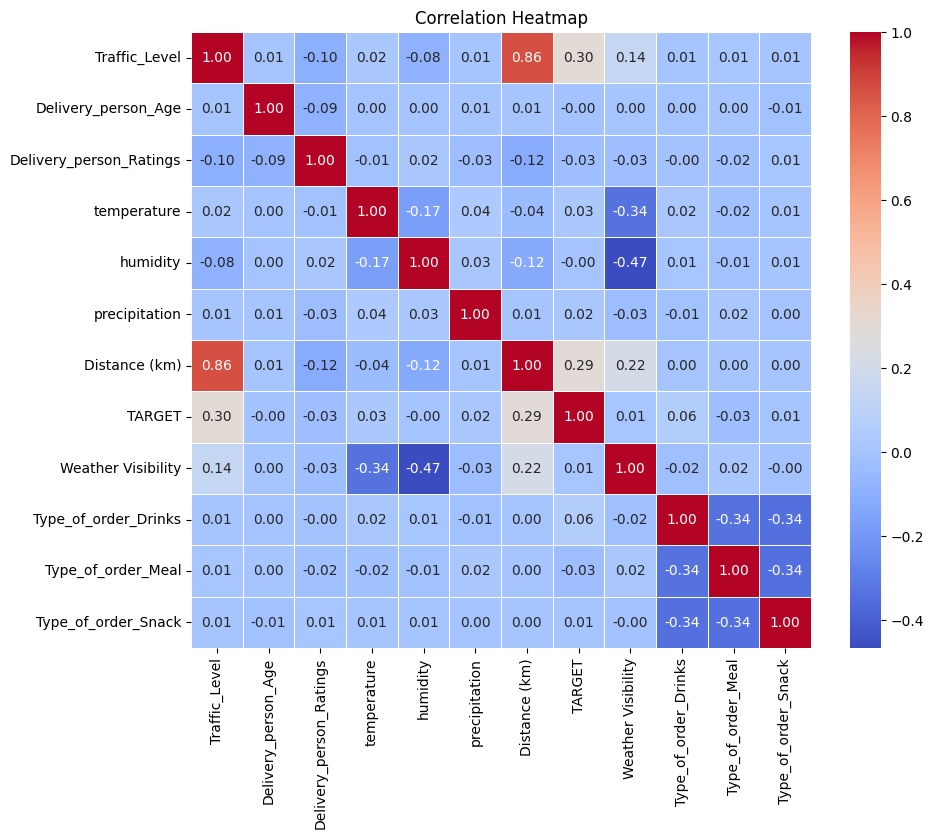

In [445]:
import seaborn as sns

corr_matrix = ds.corr()
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Show plot
plt.title("Correlation Heatmap")
plt.show()